[View in Colaboratory](https://colab.research.google.com/github/VAgni/Demo/blob/master/QSTP.ipynb)

QSTP IMAGE RECOGNITION 

Adding Pytorch to Google Colab

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
import torch 
import torch.nn as nn
import torchvision.datasets as dsets
from skimage import transform
import torchvision.transforms as transforms
from torch.autograd import Variable
import pandas as pd;
import numpy as np;
from torch.utils.data import Dataset, DataLoader
import random;
import math;

Creating Dataset

In [0]:
class FMnist(Dataset):
    def __init__(self, csv_file, transform=None):
        
        data = pd.read_csv(csv_file);
        self.x = np.array(data.iloc[:, 1:]).reshape(-1, 1, 28, 28)
        self.y = np.array(data.iloc[:, 0]);
        
        del data;
        self.transform = transform;
        
    def __len__(self):
        return len(self.x);
    
    def __getitem__(self, idx):
        item = self.x[idx];
        label = self.y[idx];
        
        if self.transform:
            item = self.transform(item);
        
        return (item, label);

Uploading Test file(test1.csv) to Google Colab 

In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving test1.csv to test1.csv
User uploaded file "test1.csv" with length 1119586 bytes


Uploading Train file(train1.csv) to Google Colab

In [6]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving train1.csv to train1.csv
User uploaded file "train1.csv" with length 3403534 bytes


Fitting and Loading data into LOADER

In [0]:
train_dataset = FMnist(csv_file='train1.csv');
test_dataset = FMnist(csv_file='test1.csv')

In [0]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True);
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True);

Visualizing random images with correct lables

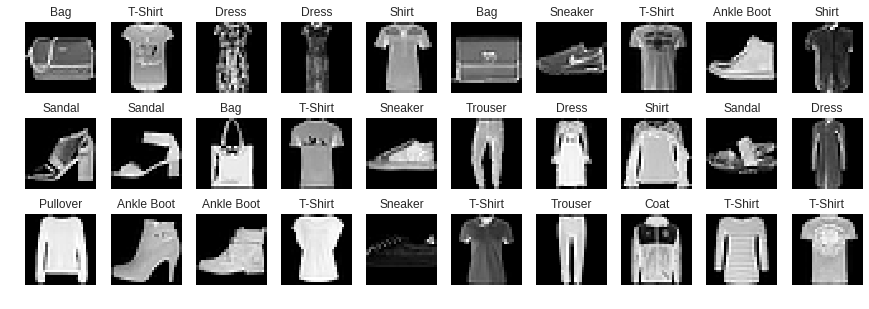

In [23]:
import matplotlib.pyplot as plt
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};
Show = plt.figure(figsize=(15,5));
col = 10;
row = 3;
for i in range(1, col*row +1):
    mod = np.random.randint(len(train_dataset));
    mod1 = train_dataset[mod][0][0,:,:]
    Show.add_subplot(row, col, i)
    plt.title(labels_map[train_dataset[mod][1]])
    plt.axis('off')
    plt.imshow(mod1, cmap='gray')
plt.show()

Creating Convolution Neural Network model

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        #Convolution 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # max pool 1
            nn.MaxPool2d(2))
        
        #Convolution 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #max pool 2
            nn.MaxPool2d(2))
        #connected linear readout
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        abc = self.layer1(x)
        abc = self.layer2(abc)
        abc = abc.view(abc.size(0), -1)
        abc = self.fc(abc)
        return abc

Training the CNN model

In [0]:
num_epochs = 10;
batch_size = 100;
learning_rate = 0.001;
cnn = CNN();
criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate);

In [0]:
Losses = [];
for epoch in range(num_epochs):
    for i, (IMGS, LBLS) in enumerate(train_loader):
        IMGS = Variable(IMGS.float())
        LBLS = Variable(LBLS)
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(IMGS)
        loss = criterion(outputs, LBLS)
        loss.backward()
        optimizer.step()
        
        Losses.append(loss.data[0]);
        
        if (i+1) % 100 == 0:
            print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))

Visualizing the Accuracy

In [27]:
cnn.eval()
true = 0
final = 0
for One, Two in test_loader:
    One = Variable(One.float())
    outputs = cnn(One)
    _, predicted = torch.max(outputs.data, 1)
    final += Two.size(0)
    true += (predicted == Two).sum()
print('Test Accuracy %.4f %%' % (100 * true / final))

Test Accuracy 85.5711 %


Minimum test accuracy for model is 85.5731%